In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random as rnd

import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from tqdm import tqdm_notebook

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, 
    IAAPiecewiseAffine, IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, ElasticTransform
)

import random
import pickle

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Data

---



In [0]:
data = np.load('/content/gdrive/My Drive/Colab Notebooks/AML/data_aug_complete.npz')

In [44]:
# training set
x_train = data['x_train']
y_train = data['y_train']

# validation set
x_val = data['x_val']
y_val = data['y_val']

# test set
x_test = data['x_test']
y_test = data['y_test']

print('Shape del training set: {} --- {}\nShape del validation set: {} --- {}\nShape del test set: {} --- {}'. format(x_train.shape, y_train.shape,
                                                                                                                 x_val.shape, y_val.shape,
                                                                                                                 x_test.shape, y_test.shape))

Shape del training set: (2157, 224, 224, 3) --- (2157,)
Shape del validation set: (415, 224, 224, 3) --- (415,)
Shape del test set: (518, 224, 224, 3) --- (518,)


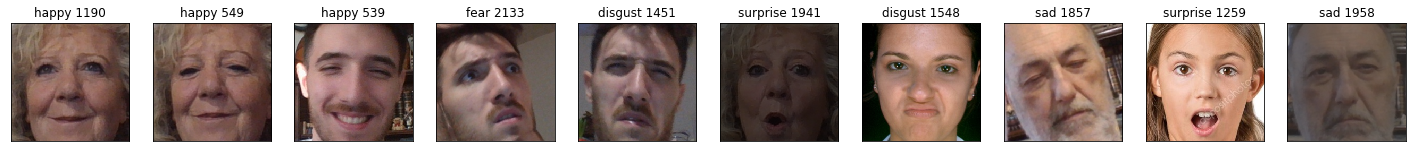

In [45]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(y_train))
    plt.imshow(x_train[l][:,:,::-1])
    plt.title(str(y_train[l])+' '+str(l))

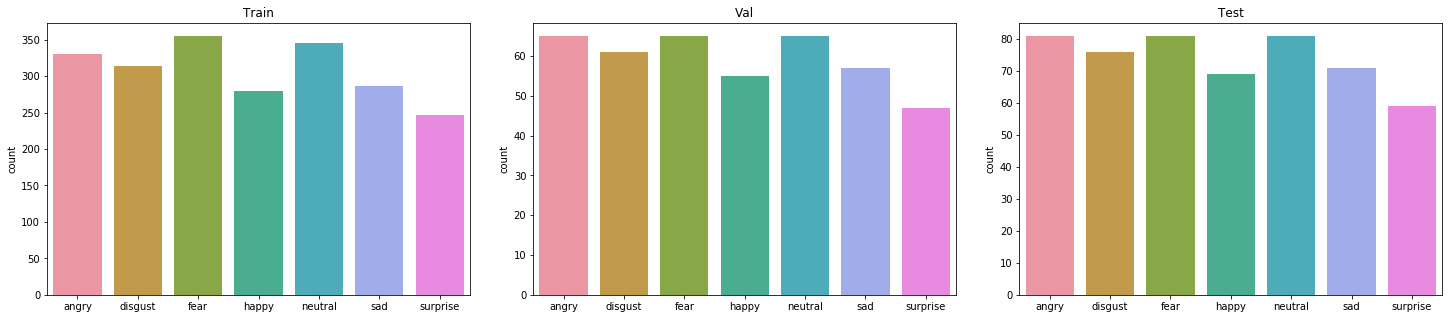

In [70]:
order =  ['angry','disgust','fear','happy','neutral','sad','surprise']

fig = plt.figure(figsize = (25,5))
fig.subplots_adjust(hspace=0, wspace=0.15)
ax = fig.add_subplot(1, 3, 1)
ax.set_title('Train')
sns.countplot(y_train, order = order)
ax = fig.add_subplot(1, 3, 2)
ax.set_title('Val')
sns.countplot(y_val, order = order)
ax = fig.add_subplot(1, 3, 3)
ax.set_title('Test')
sns.countplot(y_test, order = order)
plt.show()

# Senet50 (fine tuning as transfer learning)

---



In [7]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5ur0d9ym
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5ur0d9ym
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=186cc314b779891820d4b343bb3e1782d499676221d93829930ec79f56e1cda8
  Stored in directory: /tmp/pip-ephem-wheel-cache-pr2c9yvj/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)
y_val = le.fit_transform(y_val)
y_val = to_categorical(y_val, num_classes = 7)

In [0]:
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_val = x_val.astype('float64')
x_train = preprocess_input(x_train, version=2)
x_test = preprocess_input(x_test, version=2)
x_val = preprocess_input(x_val, version=2)

In [42]:
np.max(x_train), np.min(x_train), x_train.shape, np.max(x_val), np.min(x_val), x_val.shape, np.max(x_test), np.min(x_test), x_test.shape

(163.5047,
 -131.0912,
 (2157, 224, 224, 3),
 163.5047,
 -131.0912,
 (415, 224, 224, 3),
 255,
 0,
 (518, 224, 224, 3))

In [0]:
def create_base_model(name_layer_stop):
  base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

  for layer in base_model.layers:
    if layer.name == name_layer_stop:
      break
    else:
      layer.trainable = False
  
  return base_model

In [0]:
def create_model(base_model):
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(512, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(256, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(128, activation = 'relu'))#, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l1(0.01)))
  model.add(Dropout(.5))
  model.add(Dense(7, activation = 'softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
  return model

In [27]:
base_model = create_base_model(name_layer_stop = 'conv5_1_1x1_reduce')
model = create_model(base_model)
model.summary()


# calbacks list
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, min_delta=0.01)
filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/senet50.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_senet50 (Model)      (None, 1, 1, 2048)        26092144  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [28]:
n_epochs = 100
batch_size = 256
history_vggface = model.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_val, y_val),
                            verbose = 1, batch_size = batch_size, callbacks = callbacks_list)

Train on 2157 samples, validate on 415 samples
Epoch 1/100
2157/2157 [==============================] - 17s 8ms/step - loss: 3.0969 - acc: 0.1479 - val_loss: 2.9630 - val_acc: 0.1566
Epoch 2/100
2157/2157 [==============================] - 7s 3ms/step - loss: 2.0599 - acc: 0.1451 - val_loss: 1.9377 - val_acc: 0.1566
Epoch 3/100
2157/2157 [==============================] - 7s 3ms/step - loss: 2.0570 - acc: 0.1386 - val_loss: 1.9339 - val_acc: 0.1928
Epoch 4/100
2157/2157 [==============================] - 7s 3ms/step - loss: 2.0554 - acc: 0.1595 - val_loss: 1.9385 - val_acc: 0.1566
Epoch 5/100
2157/2157 [==============================] - 7s 3ms/step - loss: 2.0256 - acc: 0.1256 - val_loss: 1.9430 - val_acc: 0.1566
Epoch 6/100
2157/2157 [==============================] - 7s 3ms/step - loss: 2.0086 - acc: 0.1599 - val_loss: 1.9390 - val_acc: 0.1566
Epoch 7/100
2157/2157 [==============================] - 7s 3ms/step - loss: 1.9787 - acc: 0.1609 - val_loss: 1.9372 - val_acc: 0.1398
Epoch 8

In [0]:
def model_plot(history): 
  fig, axes = plt.subplots(1, 2, figsize = (25, 8))
  colors = ['coral', 'lightgreen']

  axes[0].plot(history['loss'], color = colors[0])
  axes[0].plot(history['val_loss'], color = colors[1])
  # axes[0].title('model loss')
  # axes[0].ylabel('loss')
  # axes[0].xlabel('epoch')
  axes[0].legend(['train', 'val'], loc='upper left')

  axes[1].plot(history['acc'], color = colors[0])
  axes[1].plot(history['val_acc'], color = colors[1])
  # axes[1].title('model accuracy')
  # axes[1].ylabel('accuracy')
  # axes[1].xlabel('epoch')
  axes[1].legend(['train', 'val'], loc='upper left')

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/AML/trainHistoryDict_senet50', 'wb') as file_pi:
  pickle.dump(history_vggface.history, file_pi)

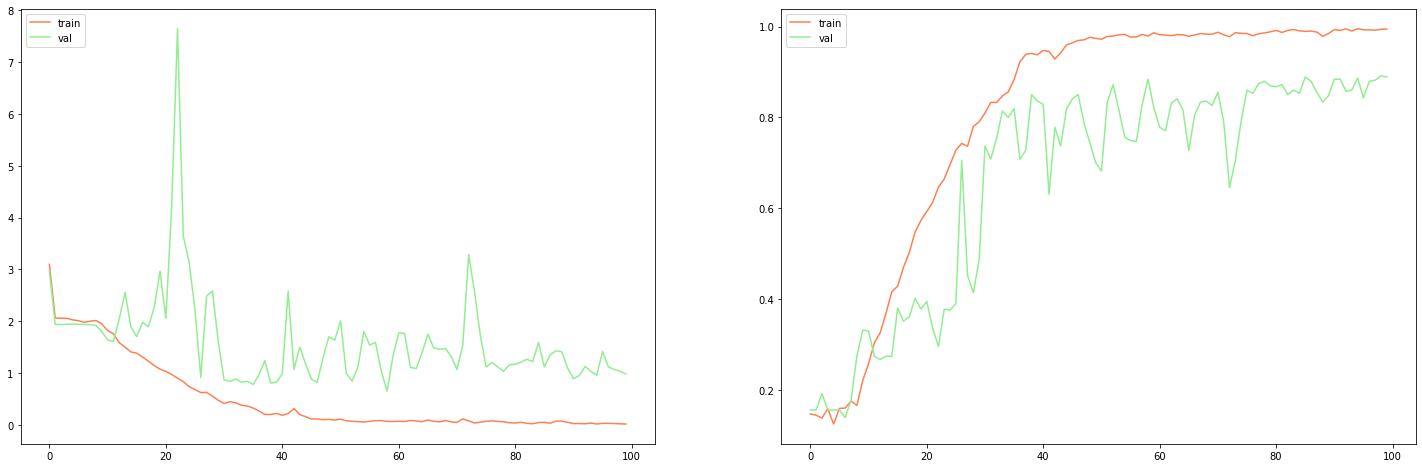

In [31]:
history = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/AML/trainHistoryDict_senet50', "rb"))
model_plot(history)

In [0]:
# load weights
model = load_model(filepath)

In [35]:
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]
loss = score[0]

print("Post-training accuracy: {} %".format(round(accuracy, 3)))
print("Post-training loss: {}".format(round(loss, 4)))

518/518 [==============================] - 5s 10ms/step
Post-training accuracy: 88.61 %
Post-training loss: 0.9181


In [36]:
y_true = np.argmax(y_test,axis=1)
y_pred = model.predict_classes(x_test)
print(classification_report(y_true, y_pred, target_names = le.inverse_transform([0,1,2,3,4,5,6])))

              precision    recall  f1-score   support

       angry       0.91      0.88      0.89        81
     disgust       0.99      0.89      0.94        76
        fear       0.74      0.91      0.82        81
       happy       0.98      0.83      0.90        69
     neutral       0.92      0.81      0.86        81
         sad       0.92      0.99      0.95        71
    surprise       0.82      0.90      0.85        59

    accuracy                           0.89       518
   macro avg       0.90      0.89      0.89       518
weighted avg       0.90      0.89      0.89       518



In [0]:
lab_test = le.inverse_transform(np.argmax(y_test, axis=1))
lab_pred = le.inverse_transform(y_pred)

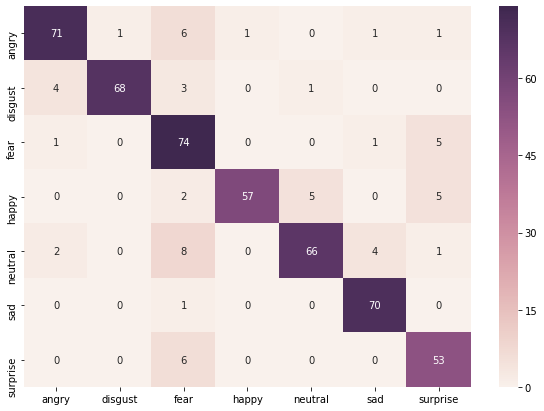

In [38]:
etichette = ['angry','disgust','fear','happy','neutral','sad','surprise']
cm = confusion_matrix(lab_test, lab_pred)
df_cm = pd.DataFrame(cm, index = etichette, columns = etichette)
plt.figure(figsize = (10,7))
cmap=sns.cubehelix_palette(1000, dark=0.2, light=0.95)
sns.heatmap(df_cm, annot=True, cmap=cmap)

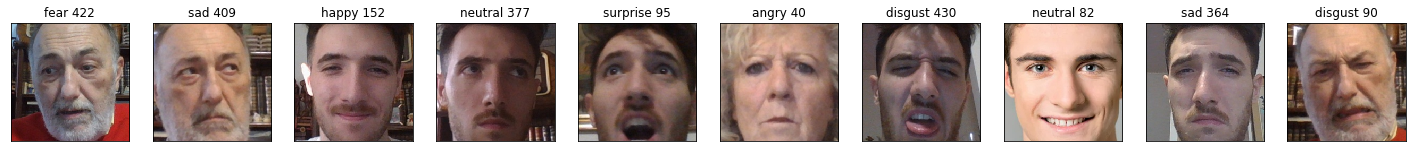

In [43]:
images = data['x_test']
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(lab_pred))
    plt.imshow(images[l][:,:,::-1])
    plt.title(str(lab_pred[l])+' '+str(l))

del images